In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

# ELMO Embedding

In [6]:
#download the model to local so it can be used again and again
!mkdir module/module_elmo2
# Download the module, and uncompress it to the destination folder. 
!curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC module/module_elmo2

mkdir: cannot create directory ‘module/module_elmo2’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
tar: module/module_elmo2: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
  0  331M    0  112k    0     0   168k      0  0:33:35 --:--:--  0:33:35  168k
curl: (23) Failed writing body (958 != 1389)


# Passing Strings

In [12]:
elmo = hub.Module("module/module_elmo2/", trainable=False)
embeddings = elmo(
["the cat is on the mat", "what are you doing in evening"],
signature="default",
as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)

In [14]:
message_embeddings.shape

(2, 6, 1024)

# Passing tokenized sentences

In [22]:
elmo = hub.Module("module/module_elmo2/", trainable=False)
tokens_input = [["the", "cat", "is", "on", "the", "mat"],
["what", "are", "you", "doing", "in", "evening"]]
tokens_length = [6, 5]
embeddings = elmo(
inputs={
"tokens": tokens_input,
"sequence_len": tokens_length
},
signature="tokens",
as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [23]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)

In [24]:
message_embeddings.shape

(2, 6, 1024)

# If want to use for multiple inputs

In [19]:
def embed_elmo2(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

embed_fn = embed_elmo2('module/module_elmo2')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
embed_fn(["i am sambit"]).shape

(1, 1024)

# Simple Neural network classifier using elmo embedding

In [2]:
df = pd.read_csv("Sentiment.csv",encoding="latin")
df = df[df["sentiment"]!="Neutral"]
df.loc[df["sentiment"]=='Negative',"sentiment"]=0
df.loc[df["sentiment"]=='Positive',"sentiment"]=1

In [3]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text
def replace_links(text, filler=' '):
        text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                      filler, text).strip()
        return text
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [4]:
import re
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "link")
    text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text

In [5]:
X = np.array(df["text"].apply(cleanText))
y = np.array(df["sentiment"])

In [6]:
from collections import Counter
Counter(y)

Counter({1: 2236, 0: 8493})

In [7]:
embed = hub.Module("module/module_elmo2")
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [8]:
import tensorflow.keras as keras 
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [13]:
def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [14]:
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
model_elmo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________


In [16]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(X, y, epochs=5, batch_size=256, validation_split = 0.2)
    model_elmo.save_weights('./model_elmo_weights.h5')

Train on 8583 samples, validate on 2146 samples
Epoch 1/5
8583/8583 [==============================] - 63s 7ms/step - loss: 0.8087 - acc: 0.7853 - val_loss: 0.6919 - val_acc: 0.7819
Epoch 2/5
8583/8583 [==============================] - 62s 7ms/step - loss: 0.6015 - acc: 0.8265 - val_loss: 0.6359 - val_acc: 0.7651
Epoch 3/5
8583/8583 [==============================] - 62s 7ms/step - loss: 0.5377 - acc: 0.8371 - val_loss: 0.5407 - val_acc: 0.8169
Epoch 4/5
8583/8583 [==============================] - 62s 7ms/step - loss: 0.4946 - acc: 0.8401 - val_loss: 0.5016 - val_acc: 0.8071
Epoch 5/5
8583/8583 [==============================] - 63s 7ms/step - loss: 0.4836 - acc: 0.8396 - val_loss: 0.4995 - val_acc: 0.8094


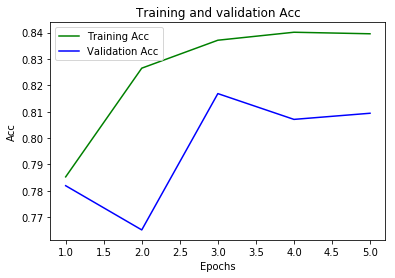

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Running prediction on saved models

In [46]:
new_text =  ['RT @FrankLuntz: Before the #GOPDebate, 14 focus groupers said they did not have favorable view of Trump.',
             'Chris Wallace(D) to be the 2nd worst partisan pontificating asshole "moderating" #GOPDebate @megynkelly'
            ]
new_text_pr = np.array(new_text, dtype=object)[:, np.newaxis]

In [47]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.load_weights('./model_elmo_weights.h5')
    import time
    t = time.time()
    predicts = model_elmo.predict(new_text_pr)
    print("time: ", time.time() - t)
    print(predicts)

time:  0.6370120048522949
[[0.17122008]
 [0.3037635 ]]
